# Setting Up the Environment

In [ ]:
!pip install shap


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from pprint import pprint
from scipy import stats
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
import shap

In [ ]:
df=pd.read_csv('./corporate_rating.csv.xls')

In [ ]:
df.columns

Index(['Rating', 'Name', 'Symbol', 'Rating Agency Name', 'Date', 'Sector',
       'currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding',
       'netProfitMargin', 'pretaxProfitMargin', 'grossProfitMargin',
       'operatingProfitMargin', 'returnOnAssets', 'returnOnCapitalEmployed',
       'returnOnEquity', 'assetTurnover', 'fixedAssetTurnover',
       'debtEquityRatio', 'debtRatio', 'effectiveTaxRate',
       'freeCashFlowOperatingCashFlowRatio', 'freeCashFlowPerShare',
       'cashPerShare', 'companyEquityMultiplier', 'ebitPerRevenue',
       'enterpriseValueMultiple', 'operatingCashFlowPerShare',
       'operatingCashFlowSalesRatio', 'payablesTurnover'],
      dtype='object')

# Exploratory Data Analysis

In [ ]:
df.head()

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790


In [ ]:
df.shape

(2029, 31)

In [ ]:
df['Rating'].value_counts()

BBB    671
BB     490
A      398
B      302
AA      89
CCC     64
AAA      7
CC       5
C        2
D        1
Name: Rating, dtype: int64

Note that multiple companies occur more than once in the dataset, meaning they were rated multiple times throughout the years, and all those ratings are noted.


In [ ]:
df['Name'].value_counts()

BCE, Inc.                      7
Walt Disney Company (The)      7
CSX Corporation                7
CoreLogic, Inc.                7
PLDT Inc.                      7
                              ..
Equinix, Inc.                  1
Centrus Energy Corp.           1
Alcoa Corporation              1
Las Vegas Sands Corp.          1
Gulfport Energy Corporation    1
Name: Name, Length: 593, dtype: int64

## Financial Ratios to Keep


We will only keep a subset of all available features. Financial ratios regarding shares and stocks of the company will be disregarder, as we want to work only with those ratios that could be found in balance sheets of Creofin's future clients. The choice of financial ratios that we will use is based on previous literature review.

Throught this notebook we will test different models and show that the chosen ratios have a meaningful impact on credit rating.

In [ ]:
cols=["currentRatio", "operatingProfitMargin", "netProfitMargin", "returnOnAssets", "returnOnEquity", "debtRatio", "debtEquityRatio", "assetTurnover"]
cols_all=["Rating", "Name", "Symbol", "Rating Agency Name", "Date", "Sector", "currentRatio", "operatingProfitMargin", "netProfitMargin", 
          "returnOnAssets", "returnOnEquity", "debtRatio", "debtEquityRatio", "assetTurnover"]

## Target Variable 

We redefine the target variable, such that only AAA, AA, A ratings are considered of low risk, and all others as high. This is because Creofin would want to be very conservative with whom to give the loan to, as in their first year of doing bussines they want to minimize the loss.

In [ ]:
rating_dict = {'AAA':'Low', 
               'AA':'Low',
               'A':'Low',
               'BBB':'High', 
               'BB':'High',
               'B':'High',
               'CCC':'High', 
               'CC':'High',
               'C':'High',
               'D':'High'}

df.Rating = df.Rating.map(rating_dict)

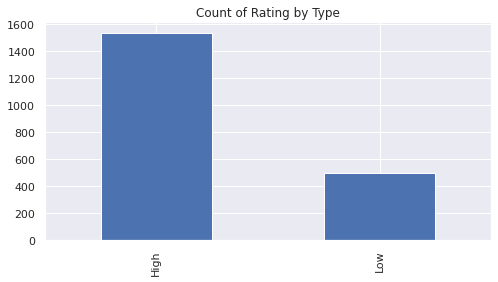

In [ ]:
df['Rating'].value_counts().plot(kind='bar',
                                 figsize=(8,4),
                                 title="Count of Rating by Type",
                                 grid=True)

In [ ]:
df=df[cols_all]

In [ ]:
df.describe()

,currentRatio,operatingProfitMargin,netProfitMargin,returnOnAssets,returnOnEquity,debtRatio,debtEquityRatio,assetTurnover
count,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2.029000e+03
mean,3.529607,0.587322,0.278447,-37.517928,143.494296,0.661495,2.328306,3.678340e+03
std,44.052361,11.224622,6.064134,1166.172220,4406.515045,0.208921,87.528880,9.565410e+04
min,-0.932005,-124.343612,-101.845815,-40213.178290,-63.814815,0.000000,-2556.419643,-9.157477e+00
25%,1.071930,0.044610,0.021006,0.019176,0.050254,0.535562,1.044617,3.872355e-01
50%,1.493338,0.107895,0.064753,0.045608,0.122383,0.640915,1.652456,6.983455e-01
75%,2.166891,0.176181,0.114807,0.077468,0.201652,0.749869,2.635023,1.096211e+00
max,1725.505005,410.182214,198.517873,0.487826,141350.211000,1.927839,2561.871795,2.553149e+06


## Outlier Detection




In [ ]:
for c in cols:

    q1 = df[c].quantile(0.25)
    q3 = df[c].quantile(0.75)
    iqr = q3 - q1 #Interquartile range
    fence_low  = q3-3*iqr
    fence_high = q1+3*iqr
    lower_out = len(df.loc[(df[c] < fence_low)  ,c])
    upper_out = len(df.loc[(df[c] > fence_high)  ,c])
    outlier_count = upper_out+lower_out
    prop_out = outlier_count/len(df)
    print(c, ": "+"{:.2%}".format(prop_out))

currentRatio : 4.53%
operatingProfitMargin : 7.29%
netProfitMargin : 8.82%
returnOnAssets : 5.82%
returnOnEquity : 12.37%
debtRatio : 2.96%
debtEquityRatio : 12.37%
assetTurnover : 3.75%


In [ ]:
df_rating_outlier = df.copy()

for c in df_rating_outlier.columns[6:31]:
    
    q1 = df_rating_outlier[c].quantile(0.25)
    q3 = df_rating_outlier[c].quantile(0.75)
    iqr = q3 - q1 #Interquartile range
    fence_low  = q3-3*iqr
    fence_high = q1+3*iqr
    
    for i in range(len(df_rating_outlier)):
        
        if df.loc[i,c] < fence_low or df.loc[i,c] > fence_high: # if Outlier
            
            df_rating_outlier.loc[i,c] = 1
        
        else: # Not Outlier
            df_rating_outlier.loc[i,c] = 0

In [ ]:
df_rating_outlier.head()

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,operatingProfitMargin,netProfitMargin,returnOnAssets,returnOnEquity,debtRatio,debtEquityRatio,assetTurnover
0,Low,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,High,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,High,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,High,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,High,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


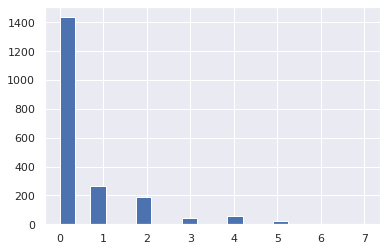

In [ ]:
df_rating_outlier["total"] = df_rating_outlier.sum(axis=1)
df_rating_outlier.total.hist(bins = 20)

In [ ]:
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df[cols] = df[cols][~((df[cols] < (Q1 - 3 * IQR)) |(df[cols] > (Q3 + 3 * IQR))).any(axis=1)]

In [ ]:
df.head()

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,operatingProfitMargin,netProfitMargin,returnOnAssets,returnOnEquity,debtRatio,debtEquityRatio,assetTurnover
0,Low,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.061510,0.037480,0.041189,0.165085,0.750500,3.008012,1.098948
1,High,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.066546,0.044062,0.053204,0.167953,0.683222,2.156783,1.207476
2,High,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.059783,0.032709,0.032497,0.133060,0.755774,3.094575,0.993501
3,High,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.042430,0.020894,0.025690,0.093279,0.724590,2.630950,1.229563
4,High,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.065354,0.042861,0.046363,0.186047,0.750796,3.012780,1.081710


In [ ]:
df=df.dropna()

## Visual Inspection

Now, let's plot instances with high/low credit rating by each two features. This could show us if there are any variables that can easily separate the two groups.

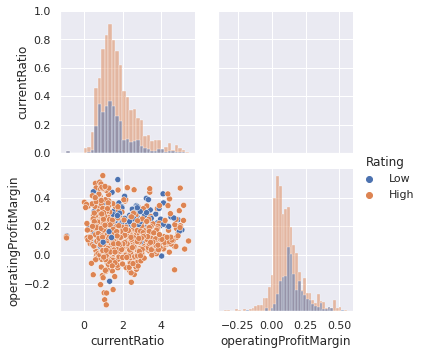

In [ ]:
g = sns.PairGrid(df[['currentRatio', 'operatingProfitMargin', 'Rating']], hue="Rating")
g.map_diag(sns.histplot, common_norm=True)
g.map_lower(sns.scatterplot)
g.add_legend()

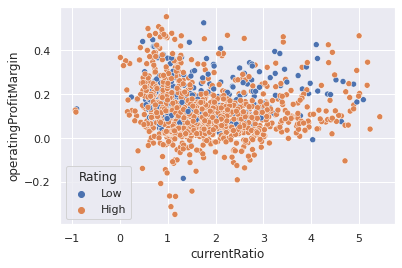

In [ ]:
sns.scatterplot(data=df, x='currentRatio', y='operatingProfitMargin', hue="Rating")

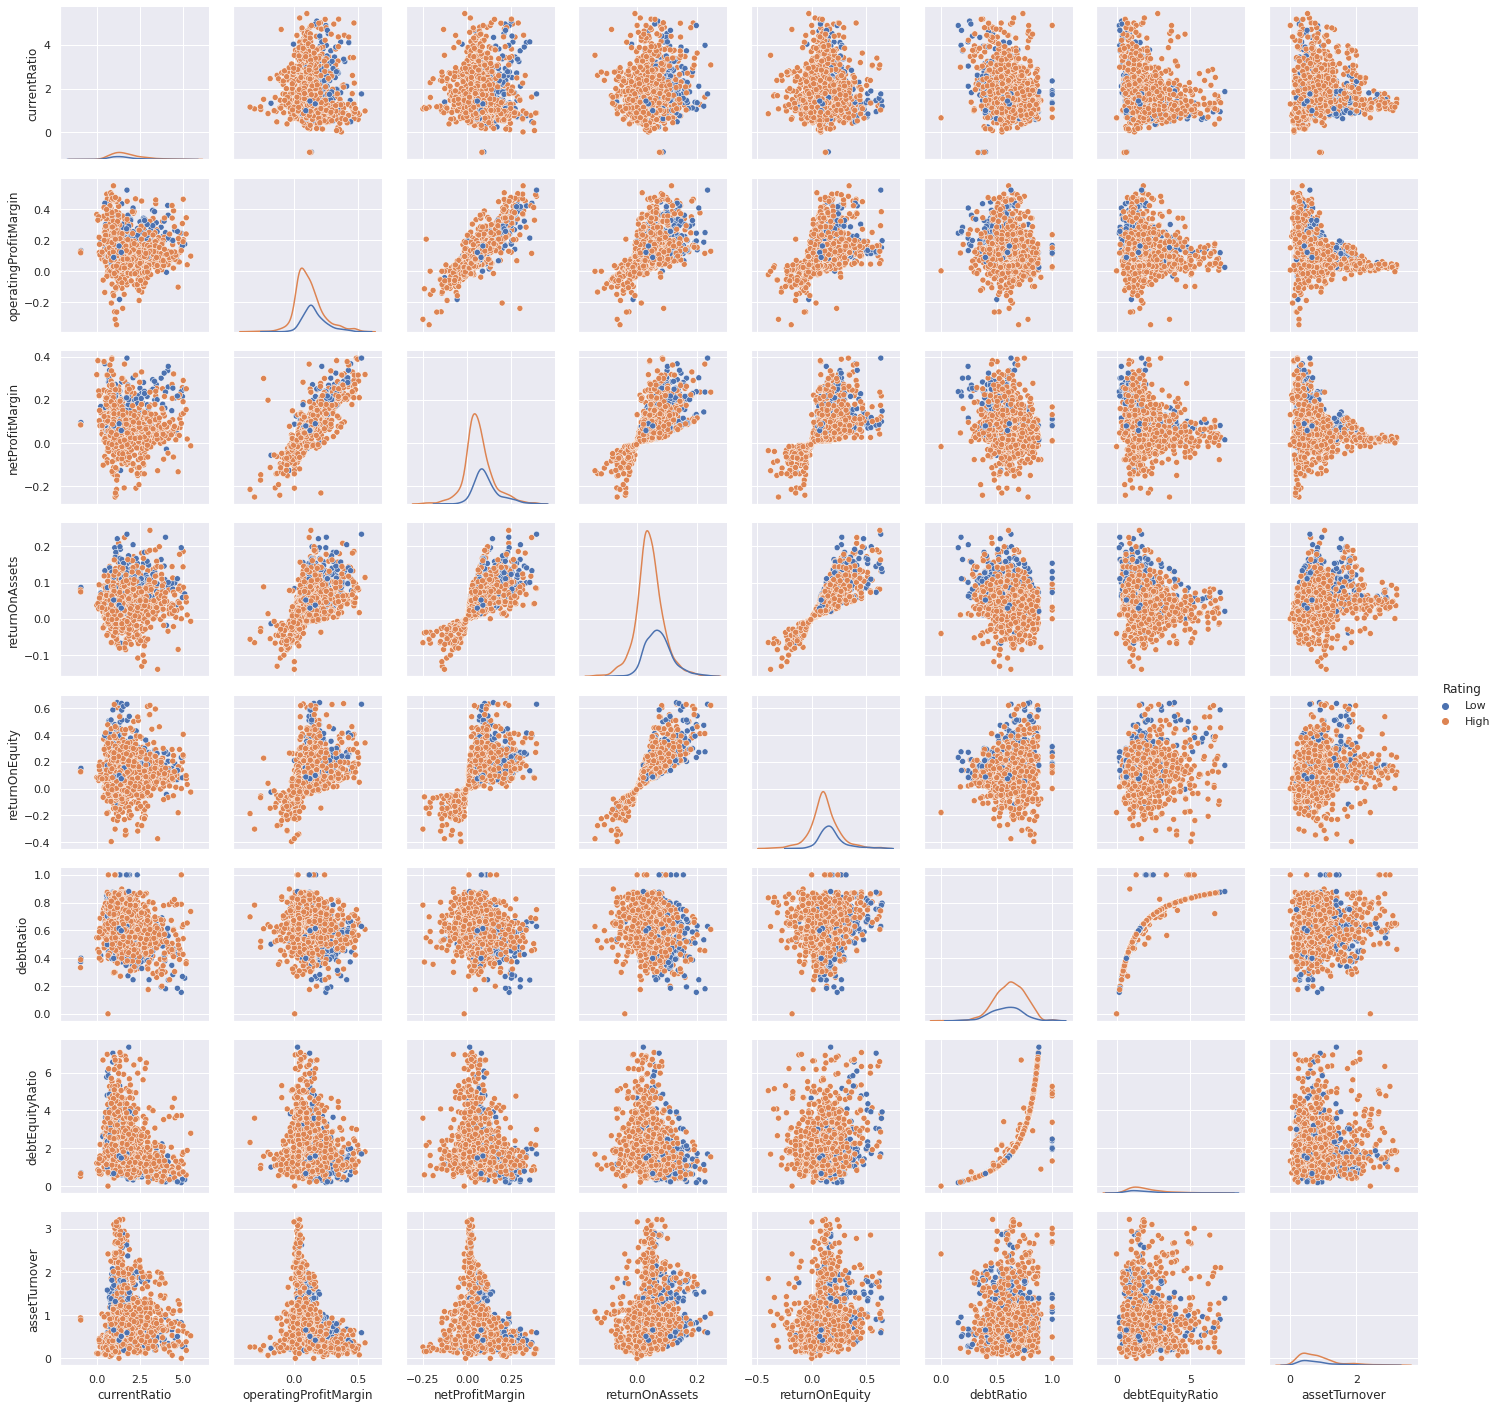

In [ ]:
g = sns.PairGrid(df, hue="Rating")
g.map_diag(sns.kdeplot, common_norm=True)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [ ]:
Preliminary impression do not give any specific variable/combination of two that would have a big dividing power.

In [ ]:
results=pd.DataFrame(columns=['statistic', 'pval'])
for c in cols:
    results.loc[c]=ttest_ind(df[df['Rating']=='High'][c], df[df['Rating']=='Low'][c], equal_var=False, 
              alternative='two-sided')

In [ ]:
print(results)

                       statistic          pval
currentRatio            3.178673  1.535534e-03
operatingProfitMargin  -8.161998  1.088506e-15
netProfitMargin       -10.603788  9.456007e-25
returnOnAssets        -12.418033  1.890463e-32
returnOnEquity         -9.620528  7.018814e-21
debtRatio               4.460407  9.489481e-06
debtEquityRatio         5.403632  8.369253e-08
assetTurnover           1.527131  1.270890e-01


## Autocorellation

In the correlogram we can see that financial ratios *netProfitMargin, returnOnEquity, debtEquityRation* are strongly correlated with the other, so we will exclude them.

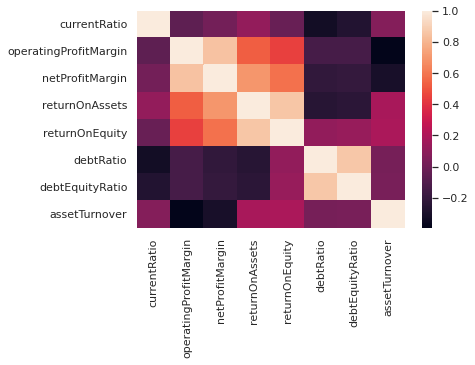

In [ ]:
sns.heatmap(df[cols].corr())

In [ ]:
cols=['Rating', 'Name', 'Symbol', 'Rating Agency Name', 'Date', 'Sector',"currentRatio", "operatingProfitMargin", "returnOnAssets","debtRatio","assetTurnover"]
df=df[cols]

In [ ]:
df.columns

Index(['Rating', 'Name', 'Symbol', 'Rating Agency Name', 'Date', 'Sector',
       'currentRatio', 'operatingProfitMargin', 'returnOnAssets', 'debtRatio',
       'assetTurnover'],
      dtype='object')

In [ ]:
df['Rating'].value_counts()

High    1190
Low      429
Name: Rating, dtype: int64

In [ ]:
df['Sector'].value_counts()

Basic Industries         224
Energy                   213
Capital Goods            192
Technology               192
Consumer Services        191
Public Utilities         188
Health Care              135
Consumer Non-Durables     97
Consumer Durables         66
Transportation            56
Miscellaneous             34
Finance                   31
Name: Sector, dtype: int64

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df.Rating)
df.Rating = le.transform(df.Rating) # encode rating
le.fit(df.Sector)
df.Sector = le.transform(df.Sector) # encode Sector


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df.head()

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,operatingProfitMargin,returnOnAssets,debtRatio,assetTurnover
0,1,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,2,0.945894,0.061510,0.041189,0.750500,1.098948
1,0,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,2,1.033559,0.066546,0.053204,0.683222,1.207476
2,0,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,2,0.963703,0.059783,0.032497,0.755774,0.993501
3,0,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,2,1.019851,0.042430,0.025690,0.724590,1.229563
4,0,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,2,0.957844,0.065354,0.046363,0.750796,1.081710


## Train/Test Split

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state = 1234) ### Split into train / test sets

In [ ]:
X_train, y_train = df_train.iloc[:,6:11], df_train.iloc[:,0]
X_test, y_test = df_test.iloc[:,6:11], df_test.iloc[:,0]

In [ ]:
X_train.head()

,currentRatio,operatingProfitMargin,returnOnAssets,debtRatio,assetTurnover
296,1.059633,0.141430,0.036792,0.730753,0.390566
396,1.050345,0.028487,0.024615,0.763804,1.777939
1224,2.058795,0.061386,0.082810,0.668218,1.280935
2016,1.855328,0.073466,0.055393,0.733008,1.189268
1460,0.774510,0.226174,0.009951,0.410538,0.044843


# Modeling

  ## K-NN Tuning

We perform a grid search over a range of possible values for the k and also parameter p, which appears in the definition of the Minkowski distance (by default implemented in Python, Euclidean distance for p=2). We tune for precision using leave-one-out cross-validation.

In [ ]:
KNN = KNeighborsClassifier()
k_range = list(range(1,10))
p = list(np.arange(1,10,0.1))

param_grid = {'p': list(range(1,10)), 'n_neighbors': k_range}
params = dict(n_neighbors = k_range, p = list(range(1,10)))
gridKNN = GridSearchCV(KNN, param_grid, cv = StratifiedKFold(), scoring = "precision", n_jobs=-1)

In [ ]:
KNN_fit = gridKNN.fit(X_train, y_train)
y_pred_KNN = KNN_fit.predict(X_test)
Precision_KNN = metrics.precision_score(y_test, y_pred_KNN)
Accuracy_KNN = metrics.accuracy_score(y_test, y_pred_KNN)
print(f"Selected k: {gridKNN.best_params_['n_neighbors']} and p: {gridKNN.best_params_['p']}")
print("KNN Precision: ", Precision_KNN)
print("KNN Accuracy: ", Accuracy_KNN)

### Partial dependece plots of kNN
Here we take a look at another feature importance measure called the *partial dependence plots*. Each is showing us approximately how changing the value of each predictor impacts the final decision. We see that current ratio is behaving in a negative trend, meaning higher currentRatio values impact the decision less. The situation is opposite for operating profit margin and return on assets, while asset turnover is exhibiting some strange patterns.

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
features = ["currentRatio", "operatingProfitMargin","returnOnAssets", "debtRatio", "assetTurnover"]
PartialDependenceDisplay.from_estimator(KNN_fit, X_test, features)

## Logistic regression

Logistic regression (LR) is the benchmark model for this sort of application, and the first option we think of when we are dealing with classification problems.

In [ ]:
LR_model = LogisticRegression(random_state=1234, solver='liblinear')
LR_model = LR_model.fit(X_train, y_train)
y_pred_LR = LR_model.predict(X_test)
Precision_LR = metrics.precision_score(y_test, y_pred_LR)
Accuracy_LR = metrics.accuracy_score(y_test, y_pred_LR)
print(f"LR Precision: {Precision_LR}")
print(f"LR Accuracy: {Accuracy_LR}")

Accuracy is not bad, but precision of 0.5 indicates something strange is happening. Examination of confusion matrix gives us more insight - model classifies almost all values as negatives (high accuracy is then achieved because of imbalance in the data - most of our data points are in the low-credit-rating category). Still, weights given to predictor variables might give us more information, so we take a look at them below.

In [ ]:
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= LR_model, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring="precision", 
                          verbose=2).fit(X_train, y_train)

In [ ]:
weight_0 = gridsearch.best_params_["class_weight"][0]
weight_1 = gridsearch.best_params_["class_weight"][1]

print(f'Best score: {gridsearch.best_score_} with param: {gridsearch.best_params_}')

In [ ]:
LR_model_w = LogisticRegression(random_state=1234, solver='newton-cg',
                                   class_weight = {0:weight_0,1:weight_1})
LR_model_w = LR_model_w.fit(X_train, y_train)
y_pred_LR_w = LR_model_w.predict(X_test)
Precision_LR_w = metrics.precision_score(y_test, y_pred_LR_w)
Accuracy_LR_w = metrics.accuracy_score(y_test, y_pred_LR_w)
print(f"W LR Precision: {Precision_LR_w}")
print(f"W LR Accuracy: {Accuracy_LR_w}")

As it turns out, best precision is achieved for the weights being approximately 0.5. That equals the unweighted case, and so the metrics are the same. Code is presented here for possible reuse or tuning for other metrics.

## XGBoost

In [ ]:
XGB_model = xgb.XGBRegressor(objective ='multi:softmax', num_class =2)
XGB_model.fit(X_train, y_train)
y_pred_XGB = XGB_model.predict(X_test)
Accuracy_XGB = metrics.accuracy_score(y_test, y_pred_XGB)
Precision_XGB = metrics.precision_score(y_test, y_pred_XGB)
Recall_XGB = metrics.recall_score(y_test, y_pred_XGB)
print("XGB Accuracy:",Accuracy_XGB)
print("XGB Precision:", Precision_XGB)
print("XGB Recall:",Recall_XGB)

XGB Accuracy: 0.7561728395061729
XGB Precision: 0.7297297297297297
XGB Recall: 0.28125


## Support Vector Machines

In [ ]:
SVC_model = svm.SVC(kernel='rbf', gamma= 2, C = 5, random_state=1234)
SVC_model.fit(X_train, y_train)
y_pred_SVM = SVC_model.predict(X_test)
Accuracy_SVM = metrics.accuracy_score(y_test, y_pred_SVM)
Precision_SVM = metrics.precision_score(y_test, y_pred_SVM)
Recall_SVM = metrics.recall_score(y_test, y_pred_SVM)
print("SVM Accuracy:",Accuracy_SVM)
print("SVM Precision:", Precision_SVM)
print("SVM Recall:", Recall_SVM)

SVM Accuracy: 0.7314814814814815
SVM Precision: 0.9090909090909091
SVM Recall: 0.10416666666666667


## Multilayer Perceptron

In [ ]:
MLP_model = MLPClassifier(hidden_layer_sizes=(5,5,5), activation='logistic', solver='adam', max_iter=1500)
MLP_model.fit(X_train, y_train)
y_pred_MLP = MLP_model.predict(X_test)
Accuracy_MLP = metrics.accuracy_score(y_test, y_pred_MLP)
Precision_MLP = metrics.precision_score(y_test, y_pred_MLP)
Recall_MLP = metrics.recall_score(y_test, y_pred_MLP)
print("MLP Accuracy:",Accuracy_MLP)
print("MLP Precision:", Precision_MLP)
print("MPL Recall:", Recall_MLP)

MLP Accuracy: 0.7037037037037037
MLP Precision: 0.0
MPL Recall: 0.0


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


## Random Forest

In [ ]:
RF_model = RandomForestClassifier(random_state=1234)
RF_model.fit(X_train,y_train)
y_pred_RF = RF_model.predict(X_test)
Accuracy_RF = metrics.accuracy_score(y_test, y_pred_RF)
Precision_RF = metrics.precision_score(y_test, y_pred_RF)
Recall_RF = metrics.recall_score(y_test, y_pred_RF)
print("RF Accuracy:",Accuracy_RF)
print('RF Precision:', Precision_RF)
print("RF Recall:", Recall_RF)

RF Accuracy: 0.7746913580246914
RF Precision: 0.7169811320754716
RF Recall: 0.3958333333333333


### Random Forest Explainer

In [ ]:
## RF explainer
RFexplain = shap.Explainer(RF_model.predict, X_test)
shapRF = RFexplain(X_test)

Exact explainer: 325it [00:25,  8.91it/s]                         


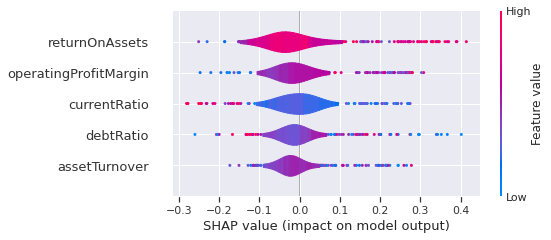

In [ ]:
shap.summary_plot(shapRF, plot_type='violin')

### Optimization of RF algorithm

In [ ]:
pprint(RF_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}


In [ ]:
## Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 400, num = 20)]

## Number of feautures to include in each split
max_features = ['auto','sqrt']

## Maximum number of levels in each tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

## Minimum number of samples in node required to split
min_samples_split = [2, 5, 10]

## Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

## Method of selecting random training sample
bootstrap = [True, False]

### Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
RF_base = RF_model

## Random search for the optimal parameters using 5-fold cross-validation
## Due to complexity we will limit ourselves to searching only on 100 combinations.
## Later we will tune with CV

RF_random = RandomizedSearchCV(estimator = RF_base, 
                               param_distributions = random_grid,
                               scoring='precision',
                               n_iter = 100,
                               cv = 5,
                               verbose = 2,
                               random_state = 1234,
                               n_jobs = -1)

### Fit the randomly searched model
RF_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 40, 60, 80, 100,
                                                         120, 140, 160, 180,
                                                         200, 220, 240, 260,
                                                         280, 300, 320, 340,
                                                         360, 380, 400

In [ ]:
RF_random.best_params_

{'n_estimators': 380,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [ ]:
RF_best_random = RF_random.best_estimator_
y_pred_RF_random = RF_best_random.predict(X_test)
Accuracy_RF_random = metrics.accuracy_score(y_test, y_pred_RF_random)
Precision_RF_random = metrics.precision_score(y_test, y_pred_RF_random)
Recall_RF_random = metrics.recall_score(y_test, y_pred_RF_random)
print("RF randomCV Accuracy:",Accuracy_RF_random)
print("RF randomCV Precision:",Precision_RF_random)
print("RF randomCV Recall:", Recall_RF_random)

RF randomCV Accuracy: 0.7746913580246914
RF randomCV Precision: 0.8108108108108109
RF randomCV Recall: 0.3125


We will try to optimize further by grid searching for the optimal combination of parameters in the neighborhood of the results from random search.

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [40,50,60],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2,3,4,5],
    'n_estimators': [20,30,40,50,60,70]
}

In [ ]:
# Create a based model
RF_base = RF_model
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RF_base, param_grid = param_grid,
                          scoring='precision',  
                          cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [40, 50, 60],
                         'max_features': ['auto'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [20, 30, 40, 50, 60, 70]},
             scoring='precision', verbose=2)

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 70}

In [ ]:
RF_best_grid = grid_search.best_estimator_
y_pred_RF_best = RF_best_grid.predict(X_test)
Accuracy_RF_best = metrics.accuracy_score(y_test, y_pred_RF_best)
Precision_RF_best = metrics.precision_score(y_test, y_pred_RF_best)
Recall_RF_best = metrics.recall_score(y_test, y_pred_RF_best)
print("RF gridCV Accuracy:",Accuracy_RF_best)
print("RF gridCV Precision:",Precision_RF_best)
print("RF gridCV Recall:", Recall_RF_best)

RF gridCV Accuracy: 0.7685185185185185
RF gridCV Precision: 0.7560975609756098
RF gridCV Recall: 0.3229166666666667


In [ ]:
result = permutation_importance(
    RF_best_grid, X_test, y_test, n_repeats=10, random_state=1234, n_jobs=-1
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

In [ ]:
forest_importances.sort_values(ascending=False)

returnOnAssets           0.055556
debtRatio                0.040123
operatingProfitMargin    0.039198
assetTurnover            0.029630
currentRatio             0.021914
dtype: float64

In [ ]:
result = permutation_importance(
    Boost_best_grid, X_test, y_test, n_repeats=10, random_state=1234, n_jobs=-1
)

boost_importances = pd.Series(result.importances_mean, index=X_test.columns)

In [ ]:
boost_importances.sort_values(ascending=False)

returnOnAssets           0.019136
operatingProfitMargin    0.018519
currentRatio             0.014198
debtRatio                0.013272
assetTurnover            0.008642
dtype: float64

## Gradient Boosting

In [ ]:
GBT_model = GradientBoostingClassifier(random_state=123)
GBT_model.fit(X_train, y_train)
y_pred_GBT = GBT_model.predict(X_test)
Accuracy_GBT = metrics.accuracy_score(y_test, y_pred_GBT)
Precision_GBT = metrics.precision_score(y_test, y_pred_GBT)
Recall_GBT = metrics.recall_score(y_test, y_pred_GBT)
print("GBT Accuracy:",Accuracy_GBT)
print("GBT Precision:", Precision_GBT)
print("GBT Recall:",Recall_GBT)

GBT Accuracy: 0.7654320987654321
GBT Precision: 0.75
GBT Recall: 0.3125


### Gradient Boosting Explainer

In [ ]:
### Gradient Boosting Explainer

Boost_explain = shap.Explainer(GBT_model.predict, X_test)
shapBoost = Boost_explain(X_test)

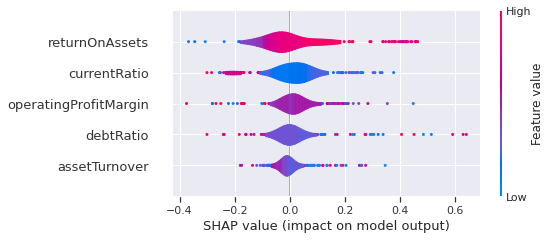

In [ ]:
shap.summary_plot(shapBoost, plot_type='violin')

We will keep and tune the parameters of Gradient Boosting CLassifier and RF models as they offer the best accuracy out of the box. Also, we will tune for maximal precision or else true positive hit rate. 

### Optimization of Boosted Trees Algorithm

Base parameters without tuning:

In [ ]:
pprint(GBT_model.get_params())

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 123,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


Parameters to optimize for:

In [ ]:
## Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 20)]

## Number of feautures to include in each split
max_features = ['auto','sqrt']

## Maximum number of levels in each tree
max_depth = [2,3,4,5,6,7,8,9,10]
max_depth.append(None)

## Minimum number of samples in node required to split
min_samples_split = [2, 5, 10]

## Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

## Learning Rate
learning_rate = [0.15, 0.1, 0.05, 0.01]

### Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate':learning_rate}

In [ ]:
### Build the random grid

Boost_base = GBT_model

## Random search for the optimal parameters using 5-fold cross-validation
## Due to complexity we will limit ourselves to searching only on 100 combinations.
## Later we will tune with CV

Boost_random = RandomizedSearchCV(estimator = Boost_base, 
                               param_distributions = random_grid,
                               scoring='precision',
                               n_iter = 100,
                               cv = 5,
                               verbose = 2,
                               random_state = 1234,
                               n_jobs = -1)

### Fit the randomly searched model
Boost_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.15, 0.1, 0.05,
                                                          0.01],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 29, 38, 48, 57, 67,
                                                         76, 86, 95, 105, 114,
                                                         124, 133, 143, 152,
                                                         162, 171, 181, 190,
                                                         200]}

The best parameters obtained by the random search:

In [ ]:
pprint(Boost_random.best_params_)

{'learning_rate': 0.05,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 20}


In [ ]:
Boost_best_random = Boost_random.best_estimator_
y_pred_Boost_random = Boost_best_random.predict(X_test)
Accuracy_Boost_random = metrics.accuracy_score(y_test, y_pred_Boost_random)
Precision_Boost_random = metrics.precision_score(y_test, y_pred_Boost_random)
Recall_Boost_random = metrics.recall_score(y_test, y_pred_Boost_random)
print("Boost randomCV Accuracy:",Accuracy_Boost_random)
print("Boost randomCV Precision:",Precision_Boost_random)
print("Boost randomCV Recall:", Recall_Boost_random)

Boost randomCV Accuracy: 0.7530864197530864
Boost randomCV Precision: 0.8636363636363636
Boost randomCV Recall: 0.19791666666666666


We will try to optimize further by grid searching for the optimal combination of parameters in the neighborhood of the results from random search.

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [3,4,5,6,7,8,9,10],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2,4,6,8,10],
    'n_estimators': [35,40,45,50,55,60],
    'learning_rate' : [0.05]
}

In [ ]:
### Search in the grid using CV

# Create a based model
Boost_base = GBT_model
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = Boost_base, param_grid = param_grid,
                          scoring='precision',  
                          cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05], 'max_depth': [3, 4, 5, 6],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [35, 40, 45, 50, 55, 60]},
             scoring='precision', verbose=2)

In [ ]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 40}

In [ ]:
Boost_best_grid = grid_search.best_estimator_
y_pred_Boost_best = Boost_best_grid.predict(X_test)
Accuracy_Boost_best = metrics.accuracy_score(y_test, y_pred_Boost_best)
Precision_Boost_best = metrics.precision_score(y_test, y_pred_Boost_best)
Recall_Boost_best = metrics.recall_score(y_test, y_pred_Boost_best)
print("Boost gridCV Accuracy:",Accuracy_Boost_best)
print("Boost gridCV Precision:",Precision_Boost_best)
print("Boost gridCV Recall:", Recall_Boost_best)

Boost gridCV Accuracy: 0.7283950617283951
Boost gridCV Precision: 0.9
Boost gridCV Recall: 0.09375


# The Best Model

The best model out of all fitted is the **boosted trees algorithm**, with precision of 90%.

In [ ]:
model_best = Boost_best_grid

# Simulate Toy Example for the Final Presentation

We will use our models to classify *fake companies* in order to better show to the audience how the models make decisions.

In [ ]:
### Create dummy dataset

badCompany = [0.5,0.1,0.009,0.9,0.1]
midCompany = [1.5,0.3,0.03,0.4,0.3]
goodCompany = [2.3, 0.4, 0.2, 0.12,0.5]

badCompanyGoodROA = [0.5,0.1,0.2,0.5,0.1]
goodCompanyBadROA = [2.3, 0.4, 0.009, 0.12,0.5]

midCompanyGoodROA = [1.5,0.3,0.2,0.4,0.3]

mixCompany = [0.5,0.5,0.2,0.4,0.3]


#create a dataframe with same features as X_train_nc but those values here
fakeCompanies = pd.DataFrame([badCompany, midCompany, goodCompany, badCompanyGoodROA, goodCompanyBadROA,midCompanyGoodROA, mixCompany], columns = X_train.columns)

In [ ]:
fakeCompanies

,currentRatio,operatingProfitMargin,returnOnAssets,debtRatio,assetTurnover
0,0.5,0.1,0.009,0.90,0.1
1,1.5,0.3,0.030,0.40,0.3
2,2.3,0.4,0.200,0.12,0.5
3,0.5,0.1,0.200,0.50,0.1
4,2.3,0.4,0.009,0.12,0.5
5,1.5,0.3,0.200,0.40,0.3
6,0.5,0.5,0.200,0.40,0.3


We create a good, mid, and a bad company based on values in the table above. Those values are determined from the literature study. Apart from them, we also study mixed companies (we assume that's the more realistic scenario) to see how models would classify them.

In [ ]:
pred_dummy = model_best.predict(fakeCompanies)

In [ ]:
pred_dummy

array([0, 0, 1, 0, 0, 0, 0])

In [ ]:
LR_fakePred = LR_model.predict(fakeCompanies)
KNN_fakePred = KNN_fit.predict(fakeCompanies)

Logistic regression is relatively easily tricked into classifying the company as good by simply making the predictor with largest coefficient bigger.

K-NN behaves better, but a mixed company with some (admittedly a bit strange and fabricated) good, bad and mid ratios still gets classified as good, even though lending to such a company might be risky (our goal was to create a model that "plays it safe").

Boosted trees a our best model. There are different techniques used to better understand this model. Here we will look at Shapley values.

In [ ]:
explainer = shap.TreeExplainer(model_best)
shap_values = explainer.shap_values(X_train)

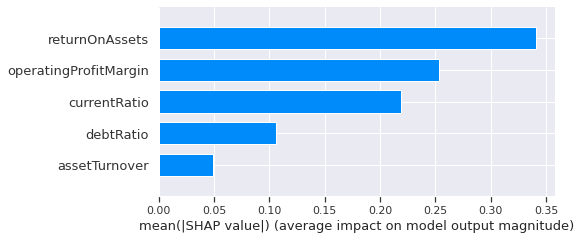

In [ ]:
shap_values = shap.TreeExplainer(model_best).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

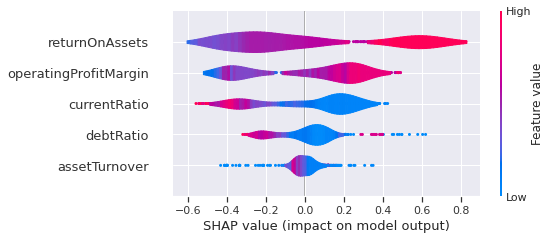

In [ ]:
shap.summary_plot(shap_values,X_train, plot_type='violin')

In [ ]:
shap_values_dummyset = shap.TreeExplainer(model_best).shap_values(fakeCompanies)

In [ ]:
shap_values_dummyset

array([[ 0.10413746,  0.02712981, -0.40600199, -0.05169138, -0.23309904],
       [ 0.10033321,  0.2898022 , -0.21905836,  0.12047561,  0.03736739],
       [-0.07565727,  0.35076684,  0.74088357,  0.48507264,  0.03989433],
       [ 0.1248017 ,  0.11119632,  0.54547673,  0.01874364, -0.51648286],
       [-0.10562931,  0.23196989, -0.59996999,  0.4356315 ,  0.01553469],
       [ 0.04820618,  0.2535095 ,  0.537601  ,  0.14843202, -0.11081725],
       [-0.06647516, -0.13146383,  0.62379278,  0.13145224, -0.07923701]])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_dummyset[2]) ### Predicted as 1

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_dummyset[0]) ### Predicted as 0 

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_dummyset[4]) ### Good Company, bad ROA -> predicted as 0

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_dummyset[6]) ### mix Company -> predicted as 0